In [1]:
import math

import jax
import jax.numpy as jnp
from jax import grad, random, vmap

from utils import *
from kernels import *

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from scipy.ndimage import gaussian_filter



In [57]:
def get_rotation_params(K, T, key):
    time = jnp.linspace(0, 2 *jnp.pi, T)[:, jnp.newaxis] #4
    radii = jnp.linspace(0.1, 2, K)
    radii = random.permutation(key, radii)
    phases = jnp.linspace(0, 2*jnp.pi, K)
    return time, radii, phases

def get_rotations(K, T, key):
    time, radii, phases = get_rotation_params(K, T, key)

    sine_waves = jnp.sin(time + phases) * radii
    cosine_waves = jnp.cos(time + phases) * radii
    X = jnp.stack([cosine_waves.T, sine_waves.T], axis=1)  
    return X

def get_infty_traj(K, T, key):
    time, radii, phases = get_rotation_params(K, T, key)

    r = radii * jnp.cos(time + phases)
    theta = radii * jnp.sin(time + phases)
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    X = jnp.stack([x.T, y.T], axis=1)
    return X

def get_expansions(K, T, key1, key2, oneD=False):
    if oneD == False:
        initial_rates = 0.05 * (random.uniform(key1, shape=(K, 2, 1)) - 0.25)
        initial_rates = random.permutation(key2, initial_rates)
    else:
        initial_rates = 0.1 * (random.uniform(key1, shape=(K, 1, 1)) - 0.5)
        initial_rates = random.permutation(key2, initial_rates)
    time_steps = jnp.arange(T)
    X = jnp.exp(initial_rates * time_steps)
    return X

def f_(x, kappa):
    return jnp.exp( (jnp.cos(x)-1) / kappa )            #Von Mises tuning curve 

def get_particle(K, N, T,key1, key2, dropout_rate = 0.1, kappa = 1):
    phi = 2*jnp.pi * random.uniform(key1, (K,))[:, jnp.newaxis, jnp.newaxis] 
    thetas = jnp.linspace(0, 2 *jnp.pi, N)[jnp.newaxis, jnp.newaxis, :] 
    time = jnp.linspace(0, 2*jnp.pi, T)[jnp.newaxis, :, jnp.newaxis] 

    X = f_(thetas-time+phi, kappa = kappa).swapaxes(1,2)

    mask = random.bernoulli(key2, 1.0 - dropout_rate, (K, N, T))
    X *= mask
    return X

def rotation_system(t, y):
    x1, x2 = y
    dx1_dt = - x2 
    dx2_dt = x1 
    return [dx1_dt, dx2_dt]

def pendulum_system(t, y):
    x1, x2 = y
    dx1_dt = x2 
    dx2_dt = -np.sin(x1) 
    return [dx1_dt, dx2_dt]

def duffing_oscillator(t, y):
    x1, x2 = y
    dx1_dt = x2 
    dx2_dt = x1 - x1**3 
    return [dx1_dt, dx2_dt]

def van_der_pol(t, y):
    x1, x2 = y
    dx1_dt = x2 
    dx2_dt = (1 - x1**2) * x2 - x1 
    return [dx1_dt, dx2_dt]

def get_oscillator(K, T, seed = 42, type=van_der_pol):
    np.random.seed(seed) 
    initial_conditions_list = np.random.uniform(low=-np.pi, high=np.pi, size=(K, 2))

    t_span = (0, 10)   
    t_eval = np.linspace(t_span[0], t_span[1], T)  
    X = np.zeros((K, 2, T))
    for i, initial_conditions in enumerate(initial_conditions_list):
        solution = solve_ivp(type, t_span, initial_conditions, t_eval=t_eval)
        x1 = solution.y[0]
        x2 = solution.y[1]

        X[i, 0, :] = x1
        X[i, 1, :] = x2
    X = jnp.array(X)
    return X

def project_X(X, key, proj_dims = 100):
    proj_matrix = random.normal(key, (proj_dims, X.shape[1]))
    proj_matrix , _ = jnp.linalg.qr(proj_matrix)                    #(N',N)
    X = jnp.einsum('lj,ijk->ilk', proj_matrix, X)                   #(K, N', T)
    return X

def add_isotropic_noise(X, key):
    noise = random.normal(key, (X.shape)) 
    X += 0.01 * (noise) 
    return X 

def add_random_modes(X, key1, key2, mean=0, std_dev=1):
    K, _, T = X.shape
    trajectories_1 = random.normal(key1, (K, T), dtype=X.dtype) * std_dev + mean
    trajectories_2 = random.normal(key2, (K, T), dtype=X.dtype) * std_dev + mean
    combined_trajectories = jnp.stack((trajectories_1, trajectories_2), axis=1)
    X = jnp.concatenate((X, combined_trajectories), axis=1)
    return X

def add_low_rank_noise(X, key1, key2, proj_dims = 3, sigma = 0.75, l2=0.1 ):
    K, N, T = X.shape    
    B = random.normal(key1, (N, proj_dims))
    B, _ = jnp.linalg.qr(B)

    time_points = jnp.linspace(0, 1, T)[None, :]
    cov_matrix = K_X_Y_squared_exponential(time_points, time_points, l2=l2)
    L = jnp.linalg.cholesky(cov_matrix + jnp.identity(T) * 1e-5)

    epsilon_t_uncorr = random.normal(key2, (K, T, proj_dims)) * sigma  
    epsilon_t = jnp.einsum("ts,ksd->ktd", L, epsilon_t_uncorr)
    noise = jnp.einsum('ktd,nd->knt', epsilon_t, B)             
    
    X += noise                                                   
    return X, noise, cov_matrix

def apply_gaussian_smoothing(data, sigma=1, axes=-1):
    smoothed_data = gaussian_filter(np.array(data), sigma=sigma, axes=axes)
    return jnp.array(smoothed_data)


def DDM(mu, sigma, dt, total_time, key):
    num_trajectories = len(mu)
    num_steps = int(total_time / dt)
    x = jnp.zeros((num_trajectories, num_steps + 1))
    ls_RT = []
    ls_acc = []

    keys = random.split(key, num_trajectories)

    for i in range(num_trajectories):
        current_key = keys[i]
        for t in range(num_steps): 
            #if jnp.abs(x[i, t]) < 1:
            normal_sample = random.normal(current_key, shape=())
            x = x.at[i, t + 1].set(x[i, t] + mu[i] * dt + sigma * jnp.sqrt(dt) * normal_sample)
            current_key, subkey = random.split(current_key)
            # else:
            #     ls_RT.append(t)
            #     ls_acc.append(1 if jnp.sign(x[i, t]) == jnp.sign(mu[i]) else -1)
                
            #     x = x.at[i, t:].set(jnp.sign(x[i, t]))
                #break
    return x, ls_RT, ls_acc

mu = np.array([ -0.64, -0.32, -0.16, -0.08, -0.04, 0.0, 0.04, 0.08, 0.16, 0.32, 0.64])  
sigma = 0.35
dt = 0.1
total_time =10




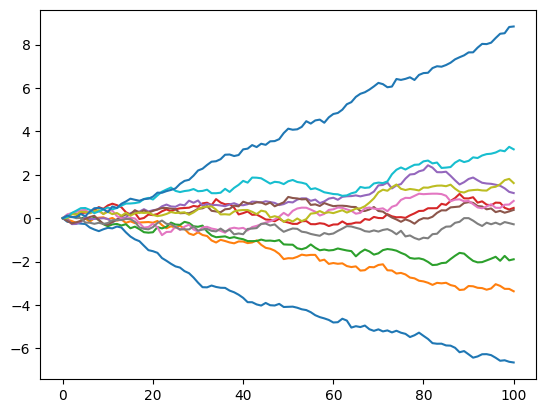

In [55]:
test = DDM(mu, sigma, dt, total_time, key, trials)[0]
for i in range(11):
    plt.plot(test[i])

In [58]:
seed = 42
key = random.PRNGKey(seed)
key1, key2, key3, key4, key5 = random.split(key, 5)

K = 100
T = 50

split = 20
d = 2 
c=30

#N = 50
X = DDM(mu, sigma, dt, total_time, key)[0][:,None,:]   #get_expansions(K, T, key1, key2, oneD=True)
#print(compute_S_all_pairs(center(X)))
X = project_X(X, key1, proj_dims=50)
#print(X.shape)
X, noise, cov_matrix = add_low_rank_noise(X, key4, key5, sigma = 1, l2=1e-1 )

X_train=X#[ids,:,:] #[split:]
X_test=X#[ids_test, :, :] #[:split]
K, N, T = X_train.shape
A = jnp.swapaxes(X_train, 0, 1)                  #(N, K, T)
A = A.reshape(N,-1)                              #(N, K*T)




#print(np.mean(compute_S(X_train)))
#print(compute_S_all_pairs(X_test))

In [22]:
X_train.shape

(100, 50, 18)

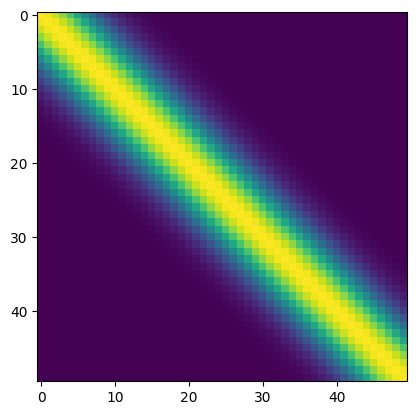

In [36]:
plt.imshow(cov_matrix)

In [116]:
np.save('/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/toy datasets/1D exp + obs noise/X_train', X_train )
np.save('/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/toy datasets/1D exp + obs noise/X_test', X_test )

Iteration 0, S: 0.6604741811752319, S_ratio: 0.13571088016033173
Iteration 10, S: 6.269232749938965, S_ratio: 0.21879231929779053
Iteration 20, S: 24.105175018310547, S_ratio: 0.25318872928619385
Iteration 30, S: 54.76569747924805, S_ratio: 0.2269033044576645
Iteration 40, S: 61.176231384277344, S_ratio: 0.2520529627799988
Iteration 50, S: 78.40711212158203, S_ratio: 0.27532970905303955
Iteration 60, S: 80.85913848876953, S_ratio: 0.25313836336135864
Iteration 70, S: 98.15850830078125, S_ratio: 0.2908211648464203
Iteration 80, S: 94.37770080566406, S_ratio: 0.28832805156707764
Iteration 90, S: 84.04045867919922, S_ratio: 0.30594226717948914
Iteration 100, S: 103.62586212158203, S_ratio: 0.31698712706565857
Iteration 110, S: 116.82128143310547, S_ratio: 0.3434772491455078
Iteration 120, S: 102.70612335205078, S_ratio: 0.32109594345092773
Iteration 130, S: 111.59613800048828, S_ratio: 0.32678931951522827
Iteration 140, S: 98.12007141113281, S_ratio: 0.3054622709751129
Iteration 150, S: 8

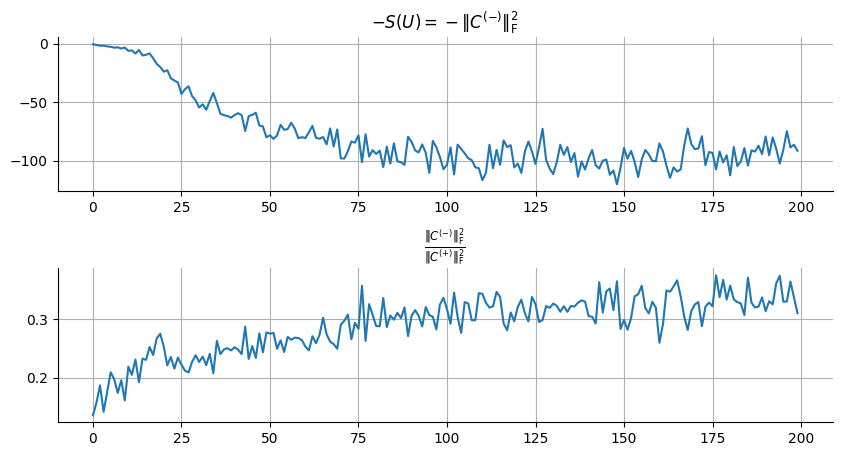

In [59]:
kernel_function=K_X_Y_squared_exponential
d = 2

from kernel_sca_inducing_points import *
wandb.init(project="", name="", mode="disabled")
params, ls_loss, ls_S_ratio = optimize(X_train, A, iterations=200, learning_rate=0.01, d=d, c=c, kernel_function=kernel_function)
wandb.finish()

get_loss_fig(ls_loss, ls_S_ratio )




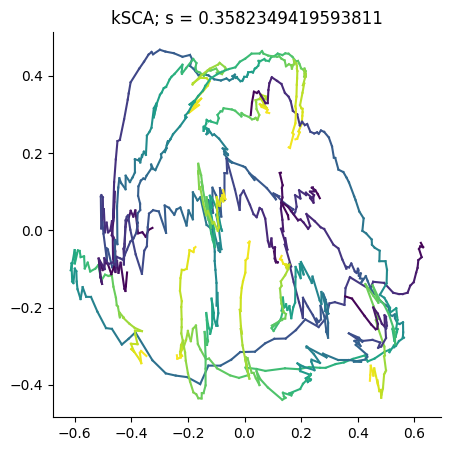

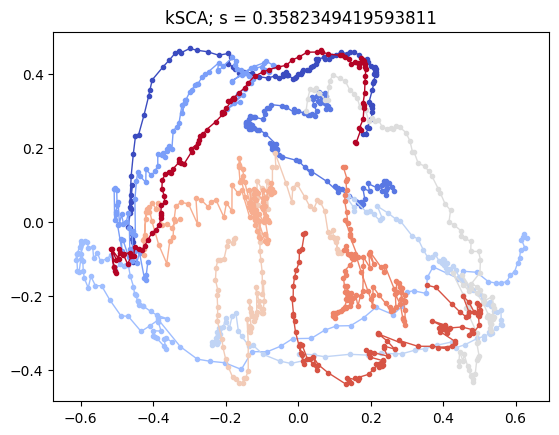

In [60]:
_, u, l2, scale = get_params(params, kernel_function=kernel_function)
K_u_u_K_u_A_alpha_H, K_A_u, K_u_u, _, _  = get_alpha(params, A, X_train, kernel_function, d)

K_test, _, _ = X_test.shape
X_reshaped = X_train.swapaxes(0,1).reshape(N,-1)
K_u_X = kernel_function(u, X_reshaped, l2=l2, scale=scale).reshape(-1,K,T).swapaxes(0,1)  
Y = jnp.einsum('ji,kjm->kim',  K_u_u_K_u_A_alpha_H, K_u_X)
Y = center(Y)

plot_2D(Y[:,:,:])
plt.title(f'kSCA; s = {compute_S_all_pairs(Y)}')

plot_2D_K_coded(Y)
# Y_smoothed = apply_gaussian_smoothing(Y, sigma=4)
# plt.figure()
# plot_2D(Y_smoothed)
# def var_explained_kernel(K_u_u_K_u_A_alpha_H, K_A_u, K_u_u):
#     return  np.trace( K_u_u_K_u_A_alpha_H.T @ K_u_u_K_u_A_alpha_H / np.trace(K_A_u @ K_u_u @ K_A_u.T )   ) #

# print(var_explained_kernel(K_u_u_K_u_A_alpha_H, K_A_u, K_u_u))

#np.save('/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/toy datasets/1D exp + obs noise/rational quadratic/Y_train', Y)
#np.save('/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/toy datasets/1D exp + obs noise/rational quadratic/ls_loss', np.array(ls_loss))
#np.save('/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/toy datasets/1D exp + obs noise/rational quadratic/ls_S_ratio', np.array(ls_S_ratio))

Iteration 0, S: 0.3406062424182892, S_ratio: 0.006627194117754698
Iteration 10, S: 3.29622483253479, S_ratio: 0.0076318588107824326
Iteration 20, S: 30.521099090576172, S_ratio: 0.009319078177213669
Iteration 30, S: 61.40239715576172, S_ratio: 0.008595992811024189
Iteration 40, S: 197.18080139160156, S_ratio: 0.007654902059584856
Iteration 50, S: 482.75518798828125, S_ratio: 0.007466124836355448
Iteration 60, S: 655.4431762695312, S_ratio: 0.007981078699231148
Iteration 70, S: 1462.63671875, S_ratio: 0.007764480076730251
Iteration 80, S: 2404.49267578125, S_ratio: 0.008714568801224232
Iteration 90, S: 2467.187255859375, S_ratio: 0.008599736727774143
Iteration 100, S: 4132.37744140625, S_ratio: 0.00824041198939085
Iteration 110, S: 2781.580810546875, S_ratio: 0.006456784904003143
Iteration 120, S: 5099.8525390625, S_ratio: 0.008295860141515732
Iteration 130, S: 7936.43505859375, S_ratio: 0.009221288375556469
Iteration 140, S: 8027.8525390625, S_ratio: 0.008491382002830505
Iteration 150,

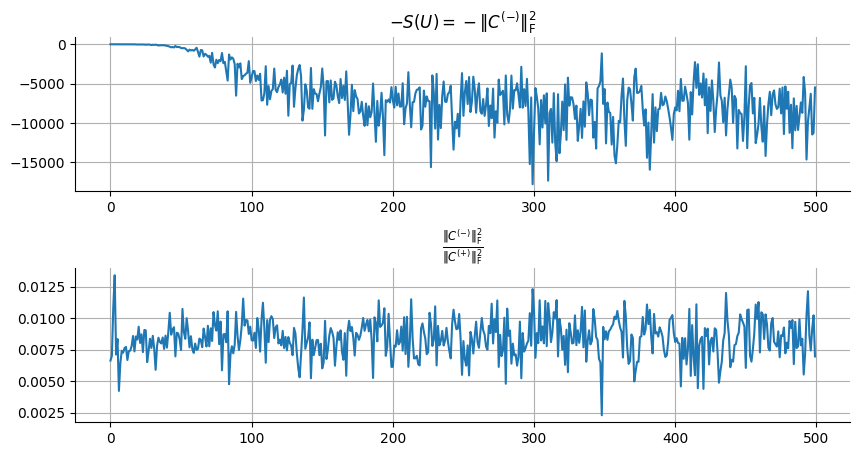

In [61]:
from linear_sca import *
wandb.init(project="", name="", mode="disabled")
U, ls_loss, ls_S_ratio = optimize(center(X_train), d=d, learning_rate=0.01, iterations=500) 
wandb.finish

get_loss_fig(ls_loss, ls_S_ratio )


Text(0.5, 1.0, 'SCA; s = 0.0027792807668447495')

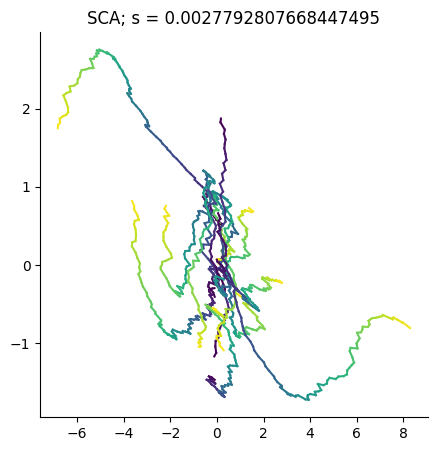

In [62]:

U_qr, _ = jnp.linalg.qr(U)        
Y = jnp.einsum('ji,kjl->kil', U_qr, center(X_train))
plot_2D(Y[:,:,:])
plt.title(f'SCA; s = {compute_S_all_pairs(Y)}')

# Y_smoothed = apply_gaussian_smoothing(Y, sigma=4)
# plt.figure()
# plot_2D(Y_smoothed)
#np.save('/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/toy datasets/1D exp + obs noise/linear/Y_test', Y)
# np.save('/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/toy datasets/1D exp + obs noise/linear/ls_loss', np.array(ls_loss))
# np.save('/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/toy datasets/1D exp + obs noise/linear/ls_S_ratio', np.array(ls_S_ratio))

Text(0.5, 1.0, 'PCA; s = -0.013086157850921154')

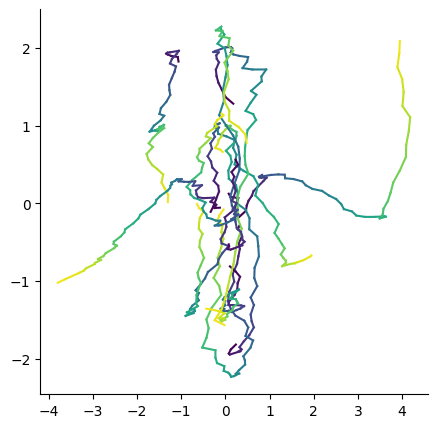

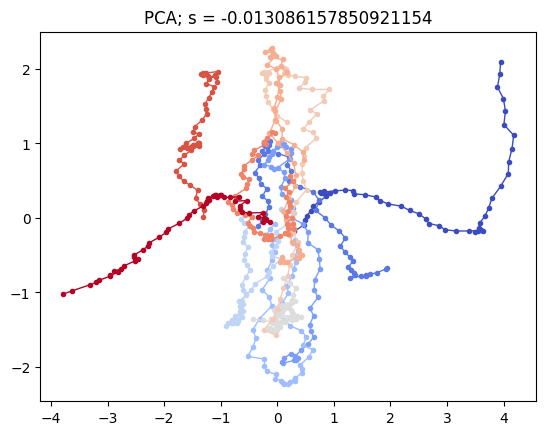

In [52]:
""" PCA """
X_pca_train = center(X_train).swapaxes(1,2).reshape(-1, N)
X_pca_test = center(X_test).swapaxes(1,2).reshape(-1, N)

num_pcs = 2
pca = PCA(num_pcs)
Y_pca = pca.fit(X_pca_train).transform(X_pca_train)
PCs = pca.components_
Y_pca = Y_pca.reshape(-1, T, num_pcs).swapaxes(1,2)
pca_variance_captured = pca.explained_variance_ratio_

plot_2D(Y_pca)
plot_2D_K_coded(jnp.array(Y_pca))
#plt.title(f"pca {var_explained(X, PCs[:2].T):.2f}")
plt.title(f'PCA; s = {compute_S_all_pairs(jnp.array(Y_pca))}')
# Y_smoothed = apply_gaussian_smoothing(Y_pca, sigma=4)
# plt.figure()
# plot_2D(Y_smoothed)
#np.save('/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/toy datasets/1D exp + obs noise/pca/Y_train', Y_pca)

In [ ]:
compute_S_all_pairs(jnp.array(Y_pca))